### 1. Import Necessary Data

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import welch, find_peaks
import pywt
from autoreject import AutoReject
import mne
from matplotlib.patches import Patch
from mne.preprocessing import ICA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

### 2. Load Data

To get the the data from the website, run this in command prompt
```
wget https://mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
unzip MindBigData-EP-v1.0.zip
```

In [2]:
def load_mindbigdata_ep(filepath, max_samples=-1, max_samples_per_digit=500, 
                       required_channels=14, sample_length=256, apply_zscore=True):
    """
    Load data from MindBigData EPOC dataset WITHOUT min-max normalization.
    Only optional z-score normalization is applied (recommended for EEG).

    Parameters:
    - filepath: Path to the EP1.01.txt data file.
    - max_samples: Maximum number of lines to read (-1 for no limit).
    - max_samples_per_digit: Max samples per digit class (0-9).
    - required_channels: EEG channels per sample (default 14).
    - sample_length: Data points per channel (default 256).
    - apply_zscore: If True, applies z-score normalization per channel.

    Returns:
    - eeg_data: Raw EEG data (num_samples, 14, 256)
    - digit_labels: Corresponding labels (0-9)
    - samples_per_class: Counts per digit class
    """
    eeg_data = []
    digit_labels = []
    samples_per_class = [0] * 10

    with open(filepath, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        collected_lines = 0
        current_channels = []
        channel_counter = 0

        for row in reader:
            if max_samples != -1 and collected_lines >= max_samples:
                break

            if len(row) < 7:
                continue

            try:
                digit_code = int(row[4])
                signal_values = row[6].split(',')
            except (ValueError, IndexError):
                continue

            # Skip invalid digits or if class quota met
            if digit_code < 0 or digit_code > 9 or \
               samples_per_class[digit_code] >= max_samples_per_digit:
                continue

            if len(signal_values) < sample_length:
                continue

            # Store raw signal (convert to float32)
            signal_array = np.array(signal_values[:sample_length], dtype=np.float32)
            current_channels.append(signal_array)
            channel_counter += 1
            collected_lines += 1

            if channel_counter == required_channels:
                # Optional z-score (no min-max!)
                if apply_zscore:
                    normalized_channels = []
                    for ch in current_channels:
                        if np.std(ch) == 0:
                            break  # Skip bad channels
                        normalized_channels.append((ch - np.mean(ch)) / np.std(ch))
                    else:  # Only append if all channels are valid
                        eeg_data.append(np.array(normalized_channels))
                        digit_labels.append(digit_code)
                        samples_per_class[digit_code] += 1
                else:
                    eeg_data.append(np.array(current_channels))
                    digit_labels.append(digit_code)
                    samples_per_class[digit_code] += 1

                current_channels = []
                channel_counter = 0

    eeg_data = np.array(eeg_data)
    digit_labels = np.array(digit_labels)

    print(f"Collected samples per digit: {samples_per_class}")
    print(f"Final data shape: {eeg_data.shape}")
    return eeg_data, digit_labels, samples_per_class

In [3]:
CHANNEL_NAMES = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", 
                 "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
FS = 128

In [4]:
x_data, y_data, class_counts = load_mindbigdata_ep("EP1.01.txt", max_samples=50000, max_samples_per_digit=500)

Collected samples per digit: [360, 340, 355, 383, 343, 365, 350, 359, 361, 351]
Final data shape: (3567, 14, 256)


Here is the visualization of the data

In [5]:
def plot_stacked_eeg(eeg_sample, label, channel_names=CHANNEL_NAMES):
    """
    Plot a stacked EEG signal plot for one digit sample.
    Each channel is offset for clarity, sharing the same x-axis (samples).
    """
    plt.figure(figsize=(12, 6))
    n_channels = eeg_sample.shape[0]
    offset = 1

    for i in range(n_channels):
        plt.plot(eeg_sample[i] + i * offset, label=channel_names[i])

    plt.yticks(np.arange(0, n_channels * offset, offset), channel_names)
    plt.xlabel("Samples")
    plt.title(f"EEG Plot of Digit '{label}'")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_one_stacked_per_digit(x_data, y_data):
    plotted = set()
    for i in range(len(y_data)):
        digit = y_data[i]
        if digit not in plotted:
            plot_stacked_eeg(x_data[i], digit)
            plotted.add(digit)
        if len(plotted) == 10:
            break

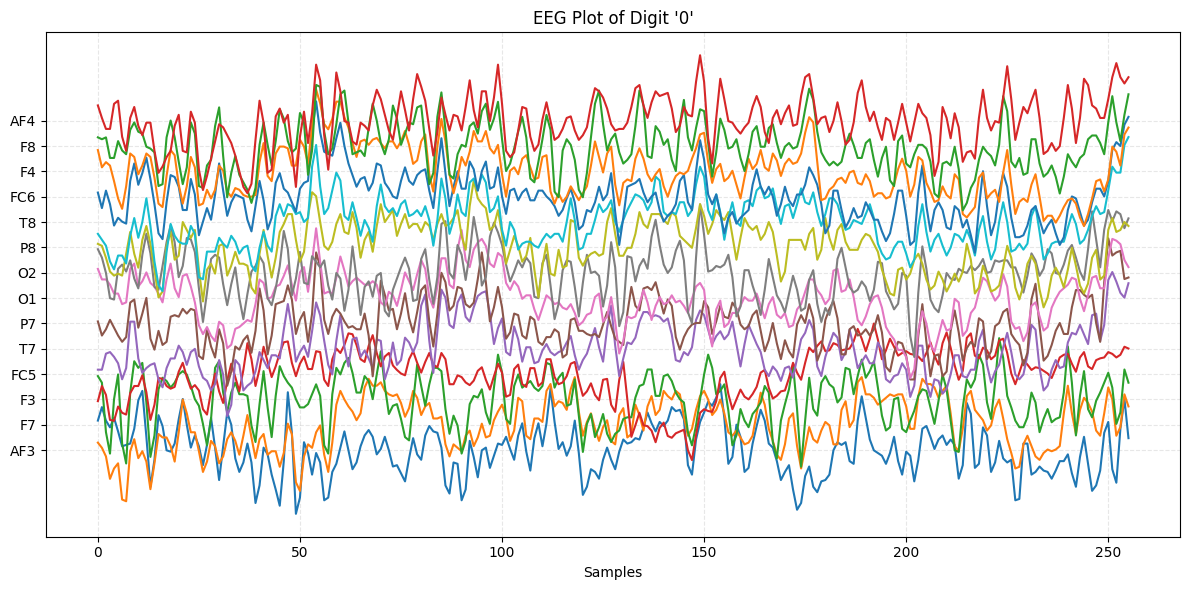

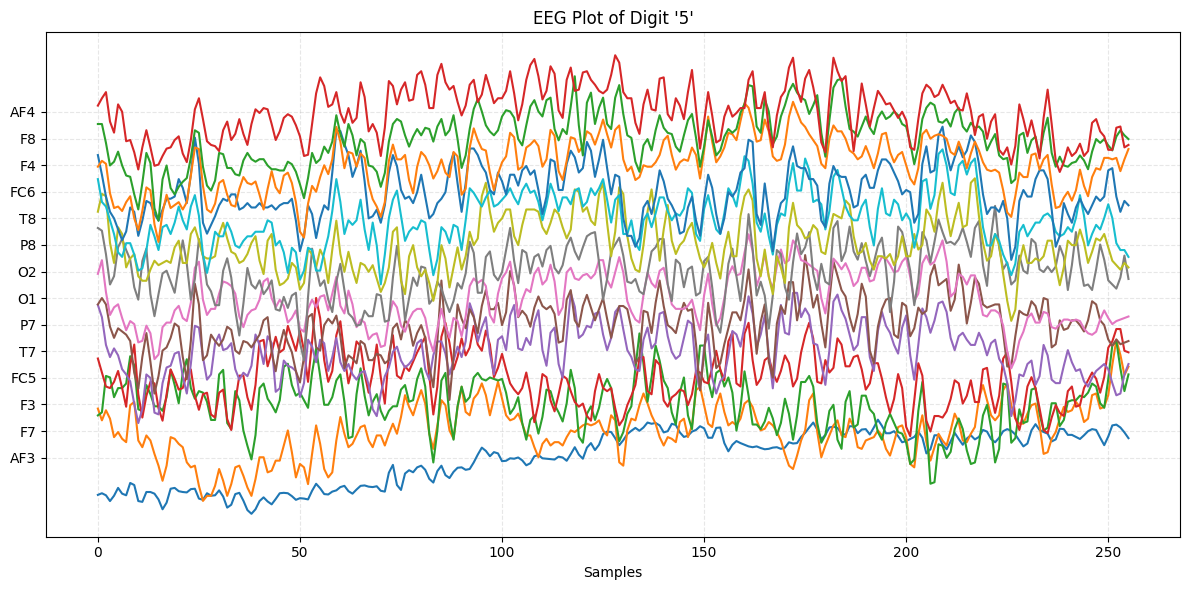

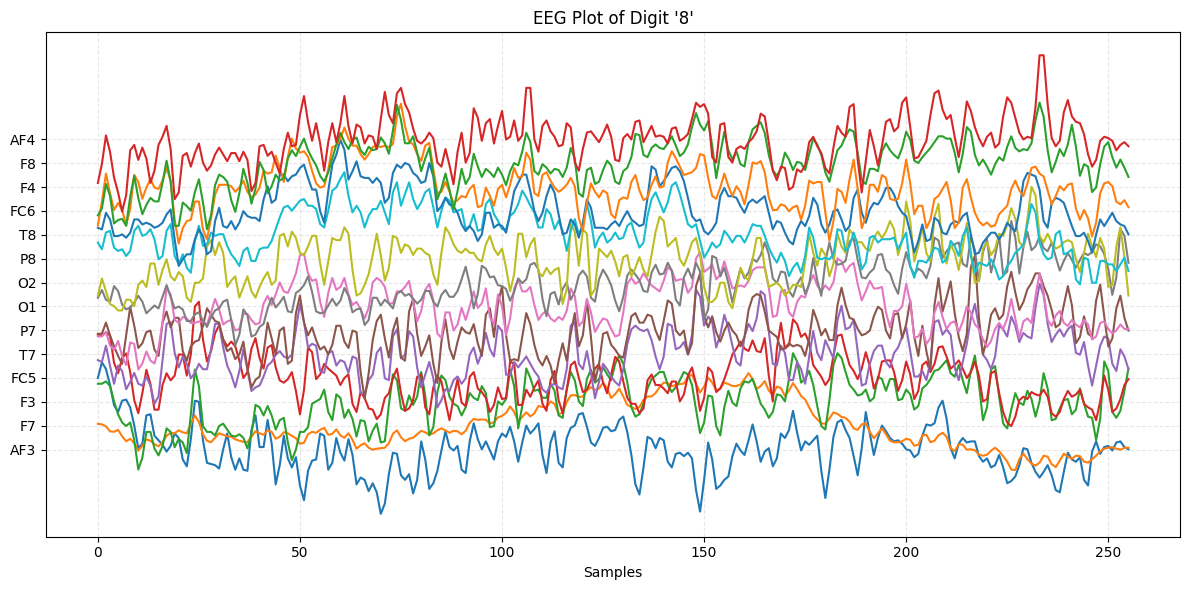

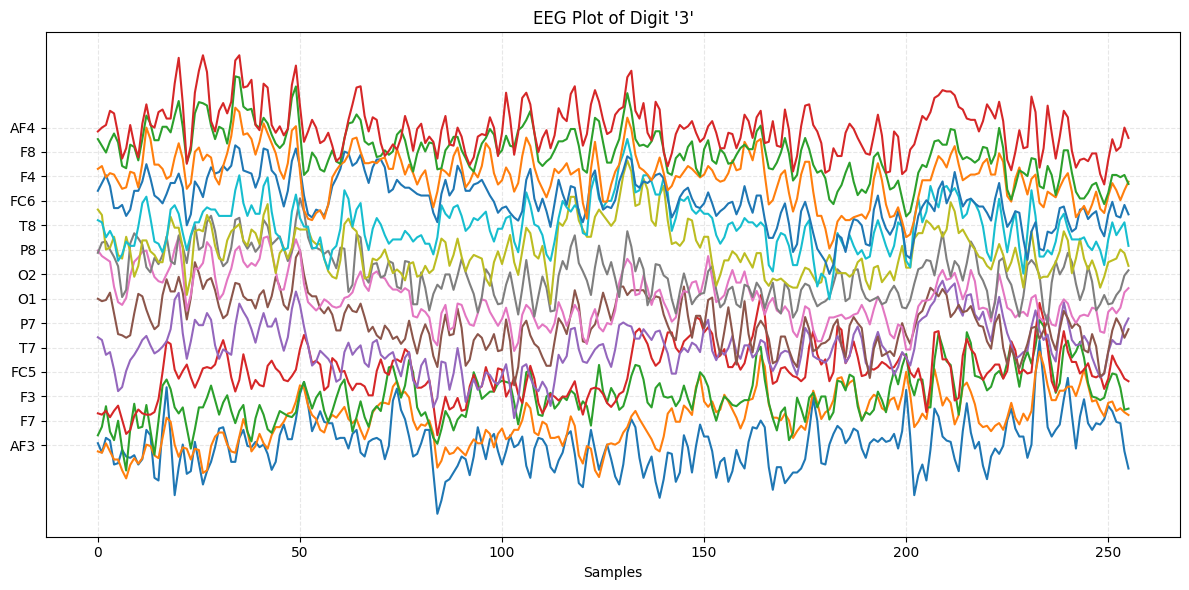

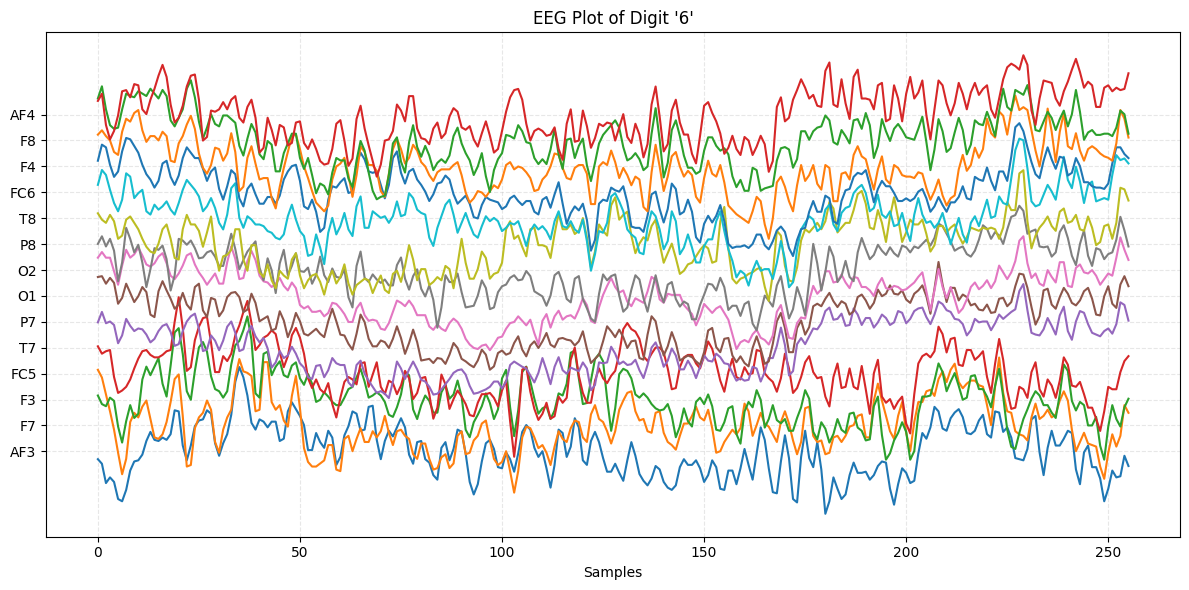

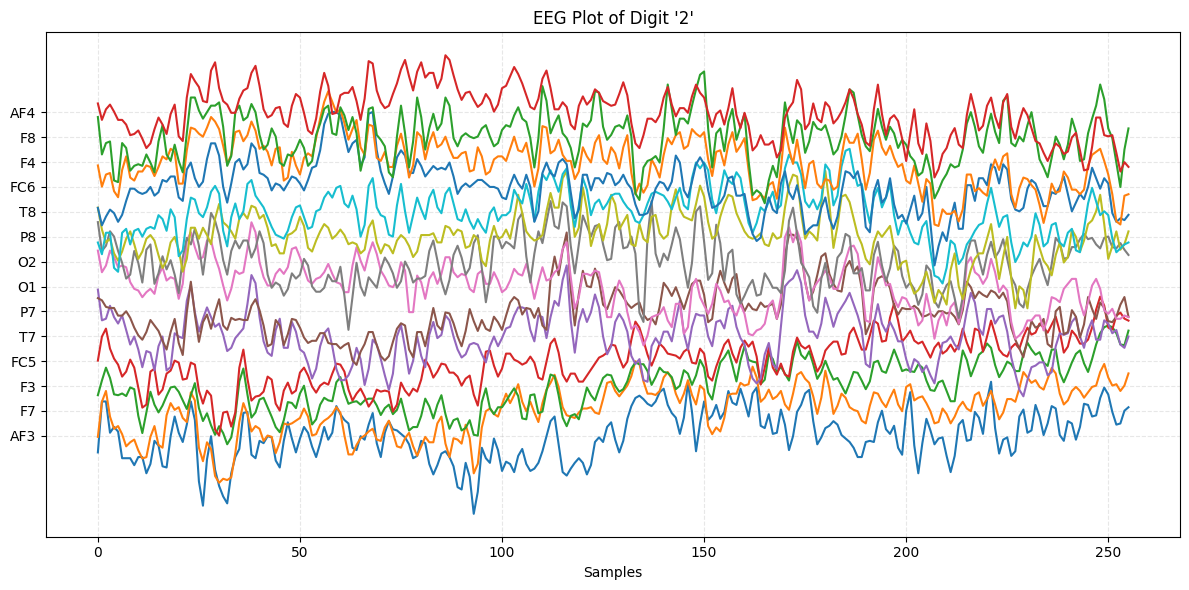

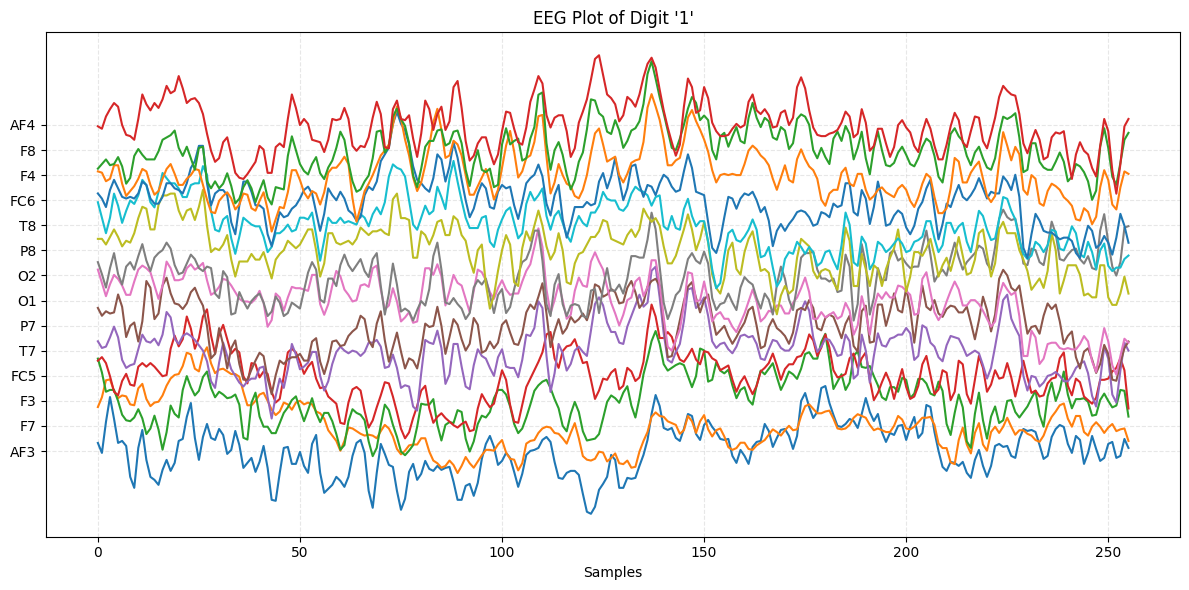

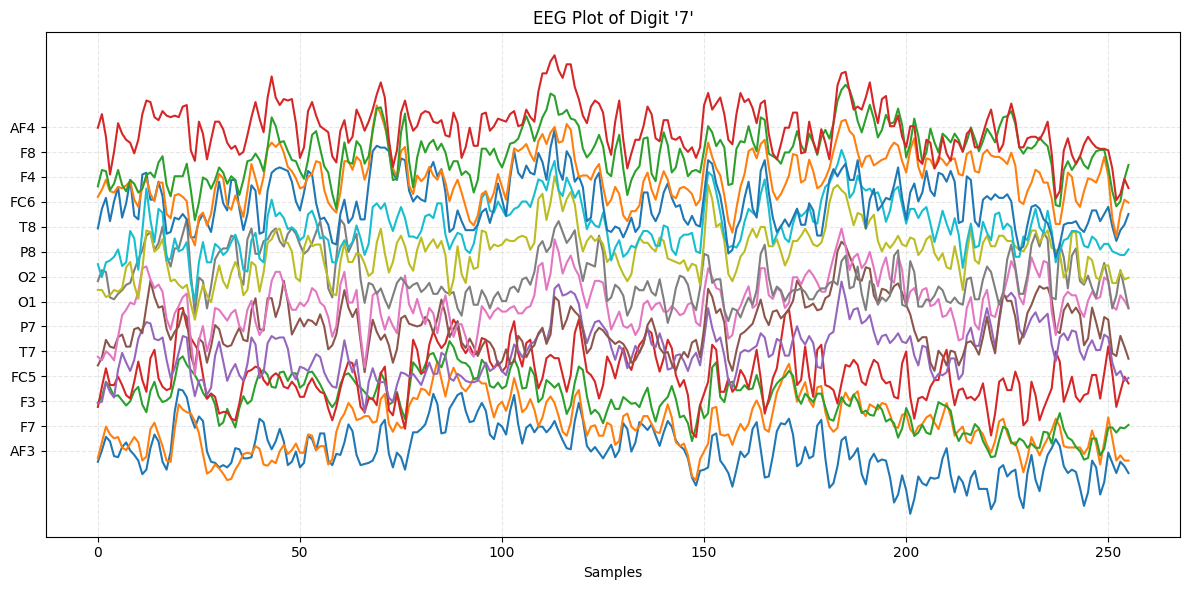

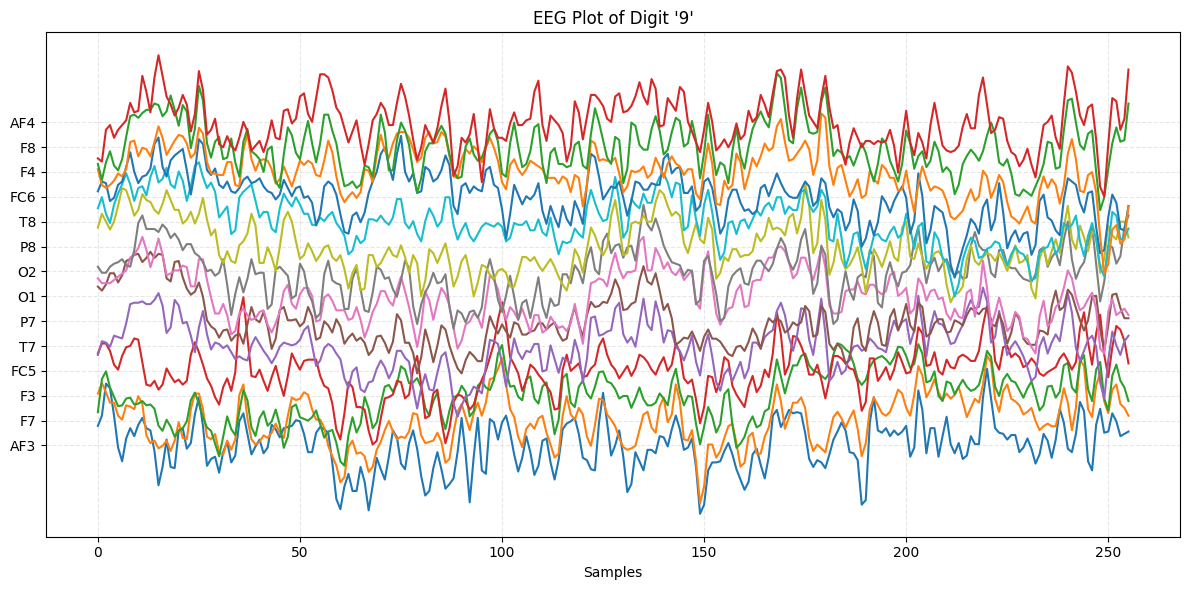

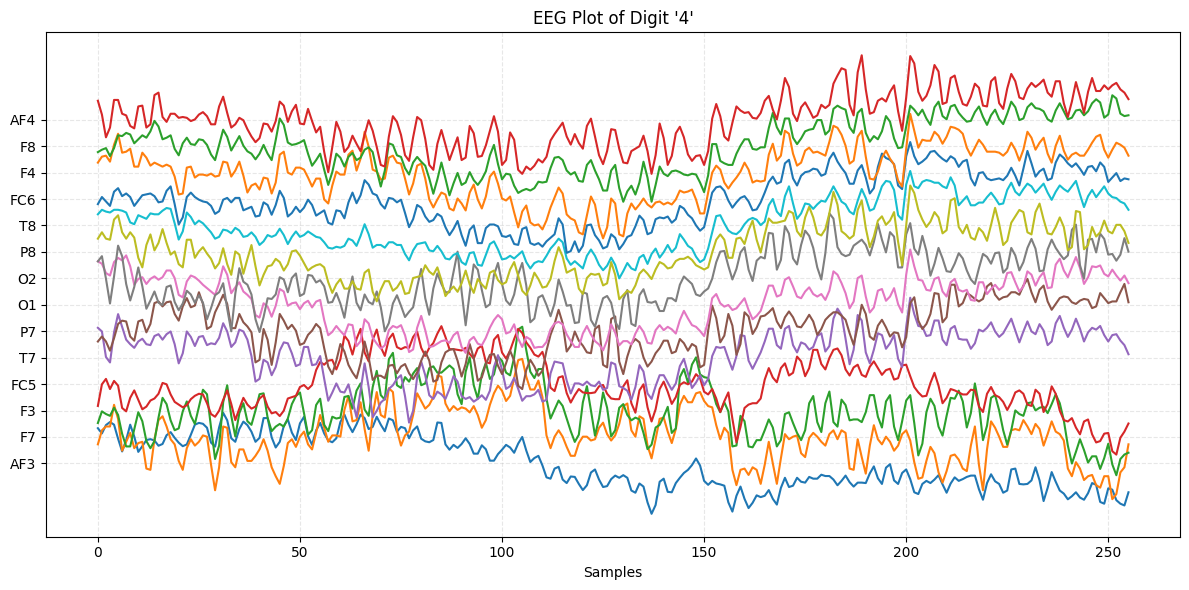

In [6]:
plot_one_stacked_per_digit(x_data, y_data)

### 3. Pre processing
#### 3.1. Bandpass Filtering
Purpose:
To isolate the frequency range relevant to brain activity and remove irrelevant noise.

	•Removes low-frequency drift (e.g., skin potentials, motion artifacts).
    
	•Removes high-frequency noise (e.g., muscle artifacts, line noise).
    
Typical EEG bands:
	•Delta: 1–4 Hz
    
	•Theta: 4–8 Hz
    
	•Alpha: 8–13 Hz
    
	•Beta: 13–30 Hz
 
	•Gamma: 30–100 Hz

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Create a Butterworth band-pass filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

def apply_bandpass_filter(data, fs, lowcut=1.0, highcut=40.0, order=4):
    """
    Apply band-pass filter to 3D EEG data [samples, channels, time].
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)

    for i in range(data.shape[0]):         # for each sample
        for ch in range(data.shape[1]):    # for each channel
            filtered[i, ch, :] = filtfilt(b, a, data[i, ch, :])
    
    return filtered

In [8]:
x_filtered = apply_bandpass_filter(x_data, FS)

Here is visualization before and after Bandpass filtering

In [9]:
def plot_raw_vs_filtered(x_raw, x_filtered, sample_index=0, channel_index=0, channel_name="AF3", fs=128):
    """
    Plot raw and filtered EEG signal for one sample and one channel.
    
    Parameters:
        x_raw (ndarray): Raw EEG data, shape (samples, channels, time)
        x_filtered (ndarray): Filtered EEG data, same shape
        sample_index (int): Index of the sample to plot
        channel_index (int): Index of the EEG channel to plot
        channel_name (str): Label of the EEG channel
        fs (int): Sampling frequency in Hz
    """
    raw_signal = x_raw[sample_index, channel_index, :]
    filtered_signal = x_filtered[sample_index, channel_index, :]
    time = np.arange(len(raw_signal)) / fs  # Convert sample index to time in seconds

    plt.figure(figsize=(12, 5))
    plt.plot(time, raw_signal, label='Raw Signal', alpha=0.6)
    plt.plot(time, filtered_signal, label='Filtered Signal (1–40 Hz)', linewidth=2)
    plt.title(f'EEG Signal Before vs After Filtering\nSample #{sample_index} | Channel: {channel_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (normalized)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

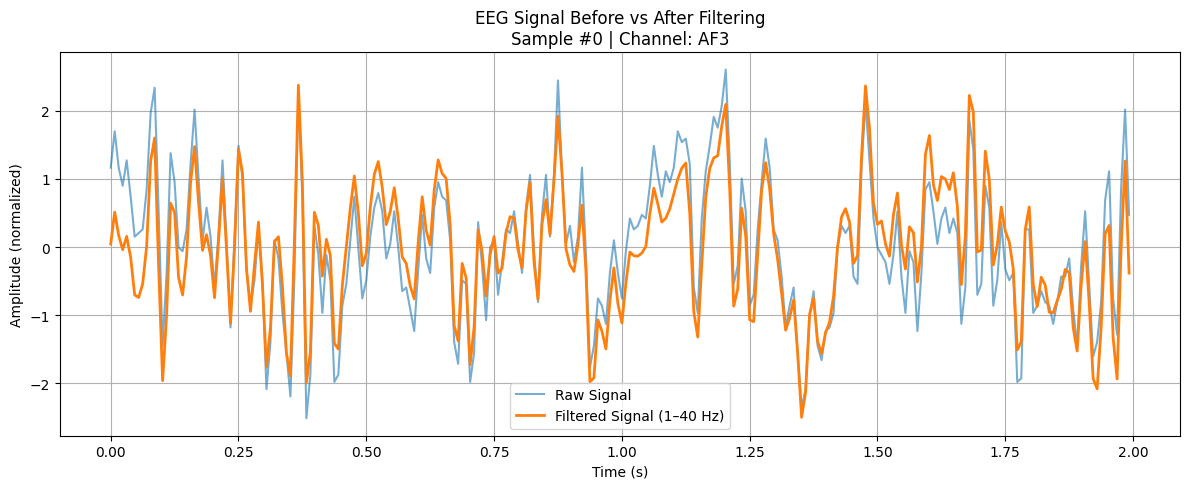

In [10]:
plot_raw_vs_filtered(x_data, x_filtered, sample_index=0, channel_index=0, channel_name="AF3", fs=128)

#### 3.2. Artifact Removal 1: Autoreject + ICA

In [11]:
def preprocess_autoreject_ica(x_filtered, fs, ch_names=None, montage_name='standard_1020',
                               max_samples=None, save_path=None, reject_log_path=None, ica_path=None):
    """
    Preprocess EEG with bandpass, AutoReject, ICA, and optionally save cleaned data,
    reject log, and ICA model.

    Parameters:
        x_filtered (ndarray): EEG data [samples, channels, time]
        fs (int): Sampling rate
        ch_names (list): EEG channel names
        montage_name (str): EEG montage
        max_samples (int): Limit sample count
        save_path (str): Path to save cleaned EEG (.npy)
        reject_log_path (str): Path to save reject log (.pkl)
        ica_path (str): Path to save ICA model (.fif)

    Returns:
        cleaned_data (ndarray): Cleaned EEG [samples, channels, time]
        reject_log (RejectLog): Fitted AutoReject log object
    """
    n_samples, n_channels, n_times = x_filtered.shape

    if max_samples is not None:
        x_filtered = x_filtered[:max_samples]
        n_samples = x_filtered.shape[0]

    if ch_names is None:
        ch_names = [f"Ch{i+1}" for i in range(n_channels)]

    info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')
    montage = mne.channels.make_standard_montage(montage_name)
    info.set_montage(montage)

    epochs = mne.EpochsArray(x_filtered, info)

    # --- AutoReject ---
    ar = AutoReject(cv=2, n_interpolate=[1], consensus=[0.5], verbose=False)
    epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True)

    # --- Downsample for ICA ---
    epochs_down = epochs_clean.copy().resample(64)

    # --- ICA ---
    ica = ICA(n_components=0.95, random_state=42, max_iter='auto')
    ica.fit(epochs_down)

    # --- Apply ICA ---
    epochs_ica = ica.apply(epochs_clean)
    cleaned_data = epochs_ica.get_data()

    # --- Save ---
    if save_path:
        np.save(save_path, cleaned_data)
        print(f"Cleaned EEG saved to: {save_path}")

    if reject_log_path:
        with open(reject_log_path, 'wb') as f:
            pickle.dump(reject_log, f)
        print(f"Reject log saved to: {reject_log_path}")

    if ica_path:
        ica.save(ica_path)
        print(f"ICA model saved to: {ica_path}")

    return cleaned_data, reject_log

In [13]:
cleaned_eeg, reject_log = preprocess_autoreject_ica(
    x_filtered,
    fs=128,
    ch_names=CHANNEL_NAMES,
    save_path='cleaned_eeg.npy',
    reject_log_path='reject_log.pkl',
    ica_path='ica_model.fif'
)

Not setting metadata
3567 matching events found
No baseline correction applied
0 projection items activated


Dropped 4 epochs: 432, 551, 2958, 3138
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components


/tmp/ipykernel_276840/3933290094.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs_down)


Fitting ICA took 1.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (12 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Cleaned EEG saved to: cleaned_eeg.npy
Reject log saved to: reject_log.pkl
Writing ICA solution to /home/bella/Masters/Code/BCI/Final/ica_model.fif...
ICA model saved to: ica_model.fif


/tmp/ipykernel_276840/3933290094.py:62: RuntimeWarning: This filename (ica_model.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(ica_path)


In [14]:
def visualize_cleaned_eeg(saved_data_path, reject_log_path, fs, ch_names, montage_name='standard_1020', max_samples=None):
    """
    Visualizes saved cleaned EEG data with reject log, ICA sources, ICA topographies, and evoked topomap.
    """
    # === Load cleaned EEG ===
    x_cleaned = np.load(saved_data_path)
    if max_samples is not None:
        x_cleaned = x_cleaned[:max_samples]
    x_vis = x_cleaned * 1e-6  # Convert µV to V

    n_samples, n_channels, n_times = x_vis.shape

    # === Load reject_log ===
    with open(reject_log_path, 'rb') as f:
        reject_log = pickle.load(f)

    # === MNE Info and Epochs ===
    info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')
    montage = mne.channels.make_standard_montage(montage_name)
    info.set_montage(montage)
    epochs = mne.EpochsArray(x_vis, info, tmin=0)

    # === Plot AutoReject summary ===
    print("📊 Showing AutoReject Summary from saved reject_log")
    bad = reject_log.bad_epochs.astype(int)
    interp = reject_log.labels.astype(int)
    reject_matrix = np.where(interp == 1, 1, 0)
    reject_matrix[bad, :] = 2
    reject_matrix_t = reject_matrix.T

    cmap = plt.matplotlib.colors.ListedColormap(['lightgreen', 'blue', 'red'])
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(reject_matrix_t, aspect='auto', cmap=cmap, interpolation='nearest')
    ax.set_yticks(np.arange(len(ch_names)))
    ax.set_yticklabels(ch_names)
    ax.set_ylabel("Channels")

    tick_step = 200
    xticks = np.arange(0, reject_matrix.shape[0], tick_step)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel("Epoch Index")

    plt.title("Autoreject Summary: Channels × Epochs", pad=10)
    legend_patches = [
        Patch(color='lightgreen', label='good'),
        Patch(color='blue', label='interpolated'),
        Patch(color='red', label='bad')
    ]
    ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.15),
              ncol=3, fancybox=True, shadow=False)
    plt.tight_layout()
    plt.show()

    # === ICA visualization ===
    print("Fitting ICA for visualization...")
    ica = ICA(n_components=n_channels, random_state=97, max_iter='auto')
    ica.fit(epochs)

    print("Plotting ICA activations (sources)...")
    ica.plot_sources(epochs, show=True)

    print(" Plotting ICA component topographies...")
    ica.plot_components(show=True)

    # === Evoked topographic map ===
    print("Plotting evoked response topomap...")
    evoked = epochs.average()
    evoked.plot_topomap(times='peaks', ch_type='eeg', show=True)


Not setting metadata
3563 matching events found
No baseline correction applied
0 projection items activated
📊 Showing AutoReject Summary from saved reject_log


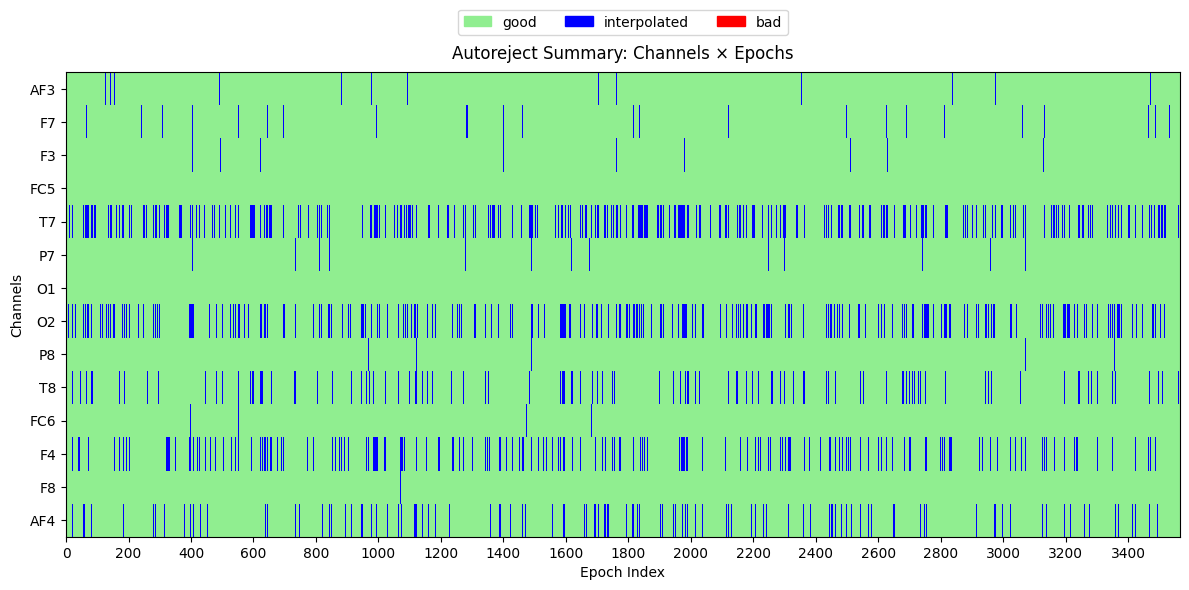

Fitting ICA for visualization...
Fitting ICA to data using 14 channels (please be patient, this may take a while)


/tmp/ipykernel_276840/1935739883.py:58: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs)


Selecting by number: 14 components


Fitting ICA took 5.5s.
Plotting ICA activations (sources)...
Not setting metadata
3563 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


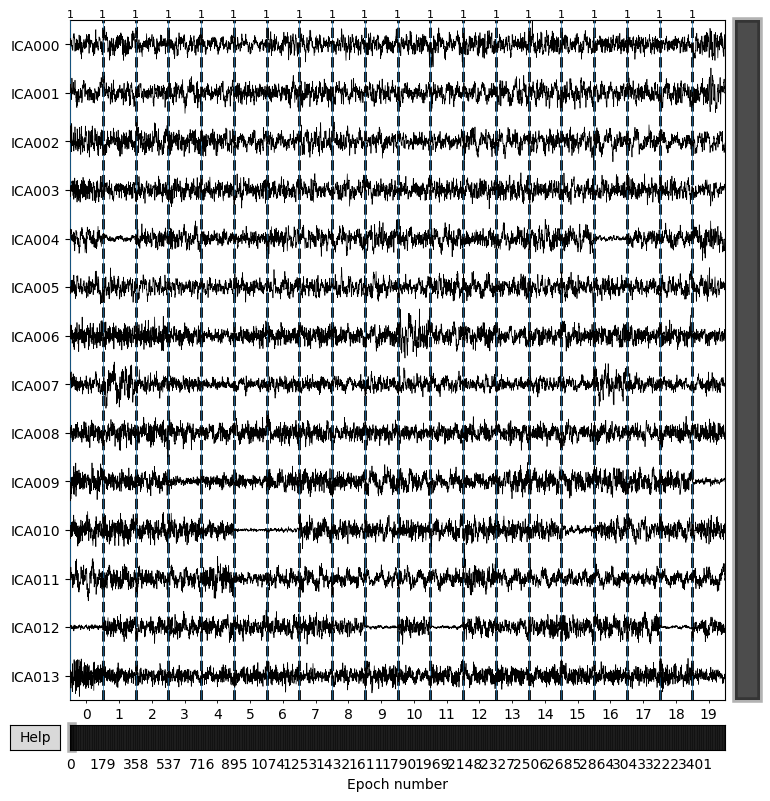

 Plotting ICA component topographies...


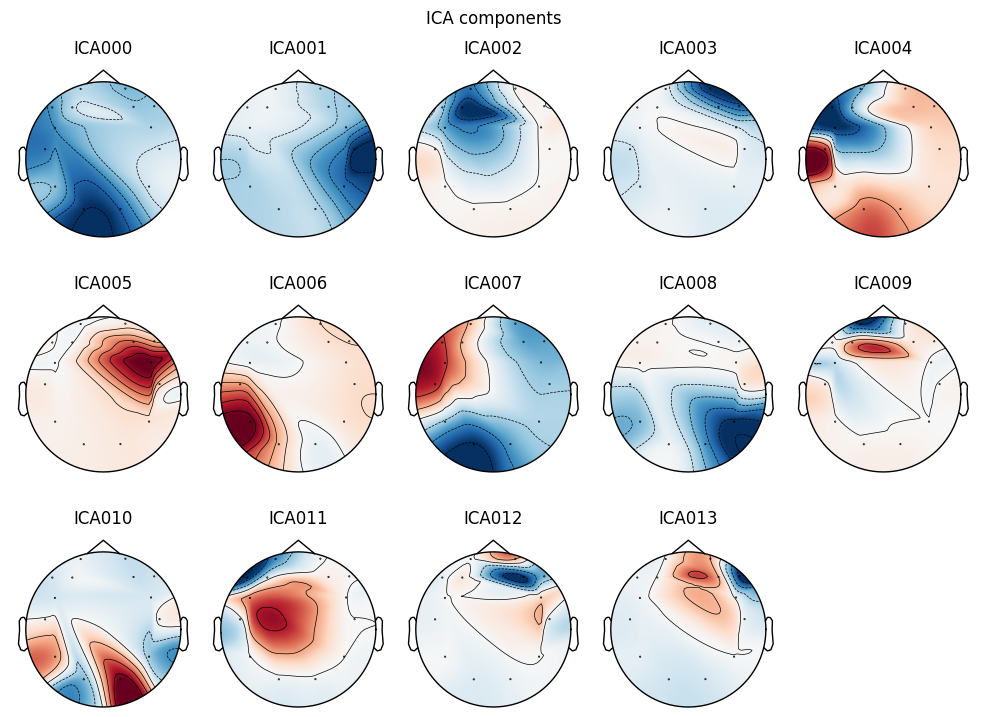

Plotting evoked response topomap...


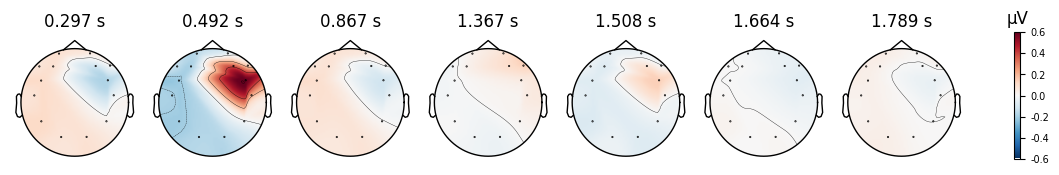

In [15]:
visualize_cleaned_eeg(
    saved_data_path='cleaned_eeg.npy',
    reject_log_path='reject_log.pkl',
    fs=128,
    ch_names=CHANNEL_NAMES,
    max_samples=None  # or use 500, 1000 etc. if you want to limit the plot
)

### Feature Extraction

cleaned_eeg.npy

   ↓

Extract time-domain features (optional)

   ↓

Extract Welch-based frequency features (band powers)

   ↓

Extract wavelet features (captures time-frequency)

   ↓

Concatenate all → Normalize → PCA (optional) → Classifier

In [31]:
def extract_freq_features(epoch, fs=250, visualize=False):
    nperseg = min(256, len(epoch))
    freqs, psd = welch(epoch, fs=fs, nperseg=nperseg)
        
    # Define standard EEG frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    features = []
    band_powers = []

    # Absolute band powers
    for band, (low, high) in bands.items():
        mask = (freqs >= low) & (freqs <= high)
        band_power = np.trapz(psd[mask], freqs[mask])
        band_powers.append(band_power)
        features.append(band_power)

    # Relative band powers
    total_power = np.trapz(psd[(freqs >= 1) & (freqs <= 45)], freqs[(freqs >= 1) & (freqs <= 45)])
    features.extend([bp/total_power for bp in band_powers])

    # Spectral edge frequency (95%)
    cum_power = np.cumsum(psd)
    sef95 = freqs[np.where(cum_power >= 0.95*cum_power[-1])[0][0]]
    features.append(sef95)

    # Mean and peak frequency
    features.append(np.sum(freqs*psd)/np.sum(psd))  # Mean frequency
    features.append(freqs[np.argmax(psd)])  # Peak frequency

    # Visualization
    if visualize:
        plt.figure(figsize=(12, 6))
        plt.semilogy(freqs, psd, label="PSD (Welch's Method)")
        plt.title("Power Spectral Density (PSD)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power Spectral Density")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Highlight frequency bands
        for band, (low, high) in bands.items():
            plt.axvspan(low, high, color='gray', alpha=0.2, label=f'{band.capitalize()} Band' if band == 'delta' else None)
        
        # Mark peak frequency
        peak_freq = freqs[np.argmax(psd)]
        plt.axvline(peak_freq, color='r', linestyle='--', label=f'Peak Frequency: {peak_freq:.2f} Hz')
        
        plt.legend()
        plt.show()

    return np.array(features)

In [25]:
def extract_wavelet_features(epoch, wavelet='db4', levels=5, visualize=False):
    """Extract wavelet-based features with optional visualization."""
    coeffs = pywt.wavedec(epoch, wavelet, level=levels)
    features = []
    
    for i, coeff in enumerate(coeffs):
        # Skip the approximation coefficients at the highest level
        if i == 0 and levels > 3:
            continue
            
        features.append(np.mean(coeff))
        features.append(np.std(coeff))
        features.append(np.sum(coeff**2))  # Energy
        features.append(np.sum(np.abs(coeff)))  # Absolute sum
        
        # Additional nonlinear measures
        features.append(skew(coeff))
        features.append(kurtosis(coeff))
    
    # Visualization
    if visualize:
        plt.figure(figsize=(12, 8))
        for i, coeff in enumerate(coeffs):
            plt.subplot(levels + 1, 1, i + 1)
            plt.plot(coeff, label=f'Level {i} Coefficients')
            plt.title(f'Wavelet Coefficients at Level {i}')
            plt.xlabel('Samples')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.tight_layout()
        plt.show()
    
    return np.array(features)

In [36]:
def extract_all_features(eeg_data, fs=250, visualize_first=1):
    """Extract all features for all channels and trials."""
    try:
        n_trials, n_channels, n_samples = eeg_data.shape
        all_features = []

        for trial in range(n_trials):
            trial_features = []
            for channel in range(n_channels):
                epoch = eeg_data[trial, channel, :]
                # Only visualize for first few
                do_visualize = (trial == 0 and channel == 0) if visualize_first else False

                # Extract features
                freq_feat = extract_freq_features(epoch, fs, visualize=do_visualize)
                wavelet_feat = extract_wavelet_features(epoch, visualize=do_visualize)

                channel_features = np.concatenate([freq_feat, wavelet_feat])
                trial_features.append(channel_features)
            
            trial_features = np.concatenate(trial_features)
            all_features.append(trial_features)

        return np.array(all_features)
    
    except Exception as e:
        print(f"An error occurred during feature extraction: {e}")
        return None


In [27]:
def normalize_and_reduce(features, n_components=None):
    """Normalize features and optionally apply PCA"""
    # Standard scaling
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features)
    
    # Dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(normalized)
        return reduced, pca
    return normalized, None

In [28]:
def plot_feature_distributions(features, feature_names=None, n_features_to_plot=20):
    """Visualize distributions of the first few features with labeled axes and a title."""
    plt.figure(figsize=(18, 10))
    
    for i in range(min(n_features_to_plot, features.shape[1])):
        plt.subplot(4, 5, i + 1)
        plt.hist(features[:, i], bins=30, color='cornflowerblue', edgecolor='black')
        plt.xlabel("Feature Value")
        plt.ylabel("Count (Trials)")
        if feature_names is not None:
            plt.title(f"{feature_names[i]}")
        else:
            plt.title(f"Feature {i+1}")
    
    plt.suptitle("Histogram of Extracted EEG Features (per Trial)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


Loading EEG data...
Data loaded with shape: (3563, 14, 256) (trials × channels × samples)
Extracting features...


/tmp/ipykernel_276840/637420331.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[mask], freqs[mask])
/tmp/ipykernel_276840/637420331.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd[(freqs >= 1) & (freqs <= 45)], freqs[(freqs >= 1) & (freqs <= 45)])


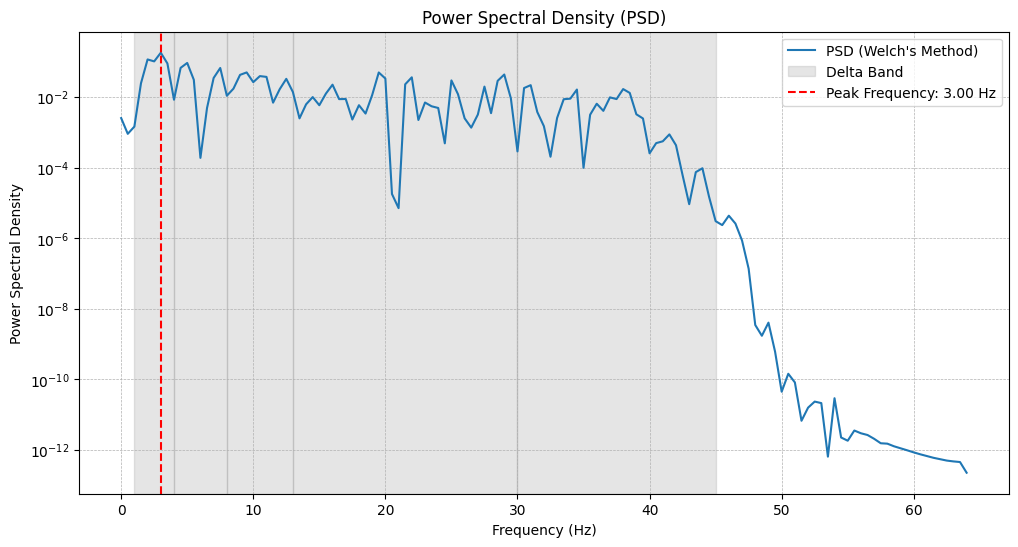

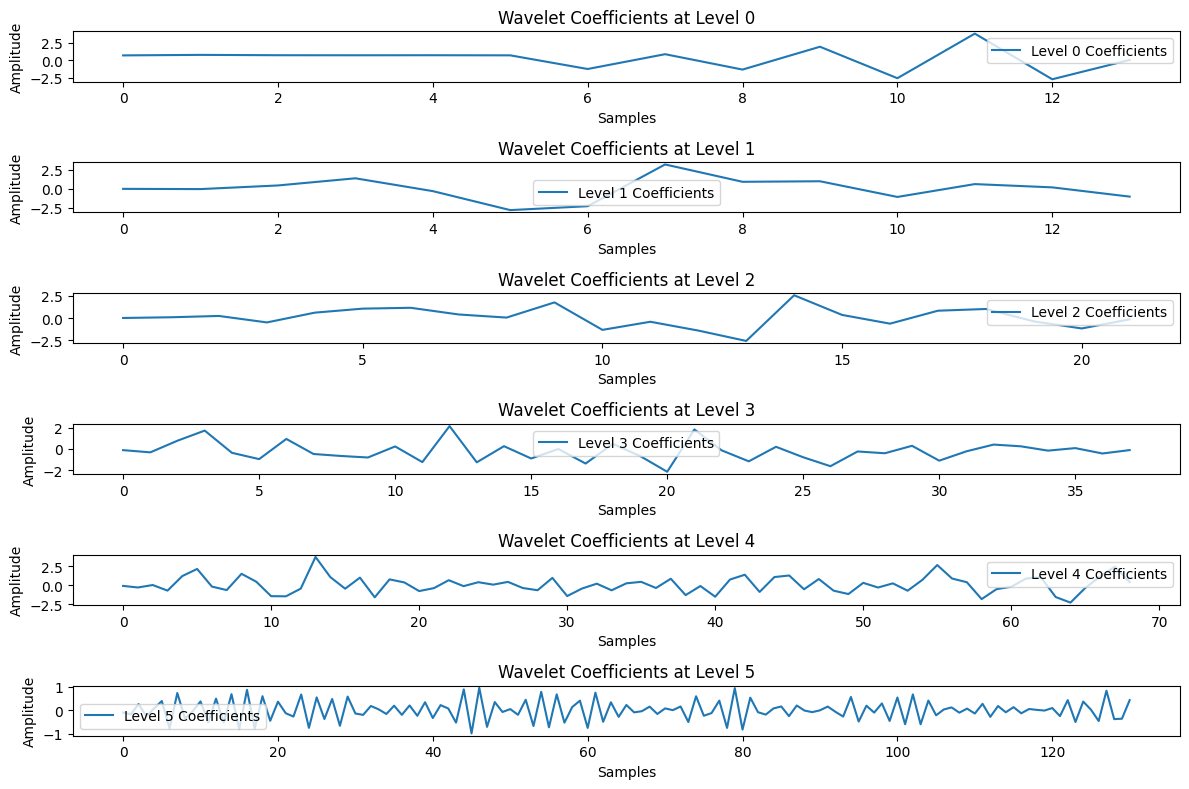

Extracted 602 features per trial
Normalizing features...
Features saved to features_extracted_eeg.npy
Plotting feature distributions...


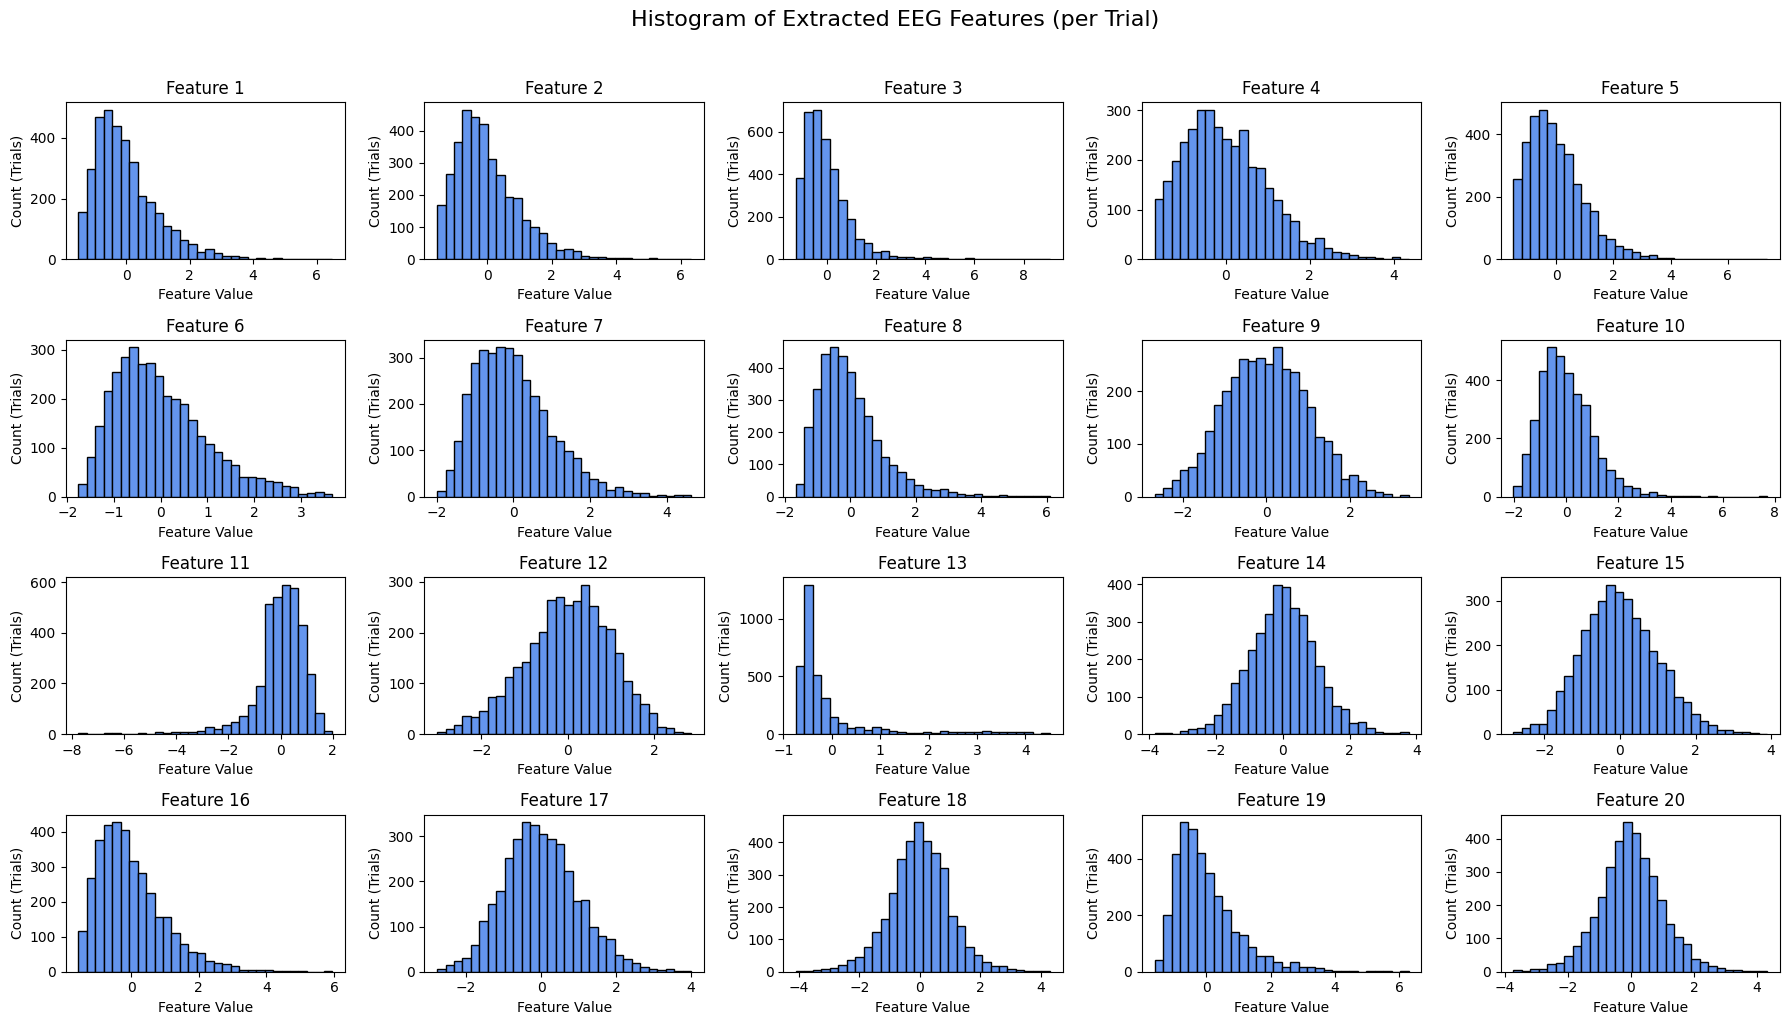

In [37]:
try:
    # 1. Load the data
    print("Loading EEG data...")
    eeg_data = np.load("cleaned_eeg.npy")
    print(f"Data loaded with shape: {eeg_data.shape} (trials × channels × samples)")
    
    # 2. Extract features
    print("Extracting features...")
    features = extract_all_features(eeg_data, fs=FS, visualize_first=True)
    if features is None or features.size == 0:
        raise ValueError("Feature extraction failed or returned empty results.")
    print(f"Extracted {features.shape[1]} features per trial")
    
    # 3. Normalize features
    print("Normalizing features...")
    normalized_features, pca = normalize_and_reduce(features)
    if normalized_features is None or normalized_features.size == 0:
        raise ValueError("Normalization or dimensionality reduction failed.")
    
    # 4. Save results
    np.save("features_extracted_eeg.npy", normalized_features)
    print(f"Features saved to features_extracted_eeg.npy")
    
    
    # 5. Visualization
    print("Plotting feature distributions...")
    plot_feature_distributions(normalized_features)
    
    if pca:
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
        plt.figure()
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Explained Variance')
        plt.show()
        
except FileNotFoundError:
    print(f"Error: Input file '{cleaned_eeg.npy}' not found. Please check the file path.")
except ValueError as ve:
    print(f"Value Error: {str(ve)}")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")